# Project 1: Data Cleaning, Visualization, and Mining

In [83]:
# Add all of your import statements here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import matplotlib.mlab as mlab
import plotly.offline as py
import plotly.graph_objs as go
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#from datascience import *
import missingno as msno
import seaborn as sns
sns.set()
py.init_notebook_mode(connected=True)
import plotly

# Setup, Cleaning, Organizing, and Exploring the Data

Let's now try to read in the data, clean up the data by getting rid of NAs, and explore the data. Feel free to use any commands to do these parts. As always, report your steps in the writeup.

In [2]:
df = pd.read_csv('acs2015_county_data.csv')

## Nullity Matrix

Check the density of NAs in each feature

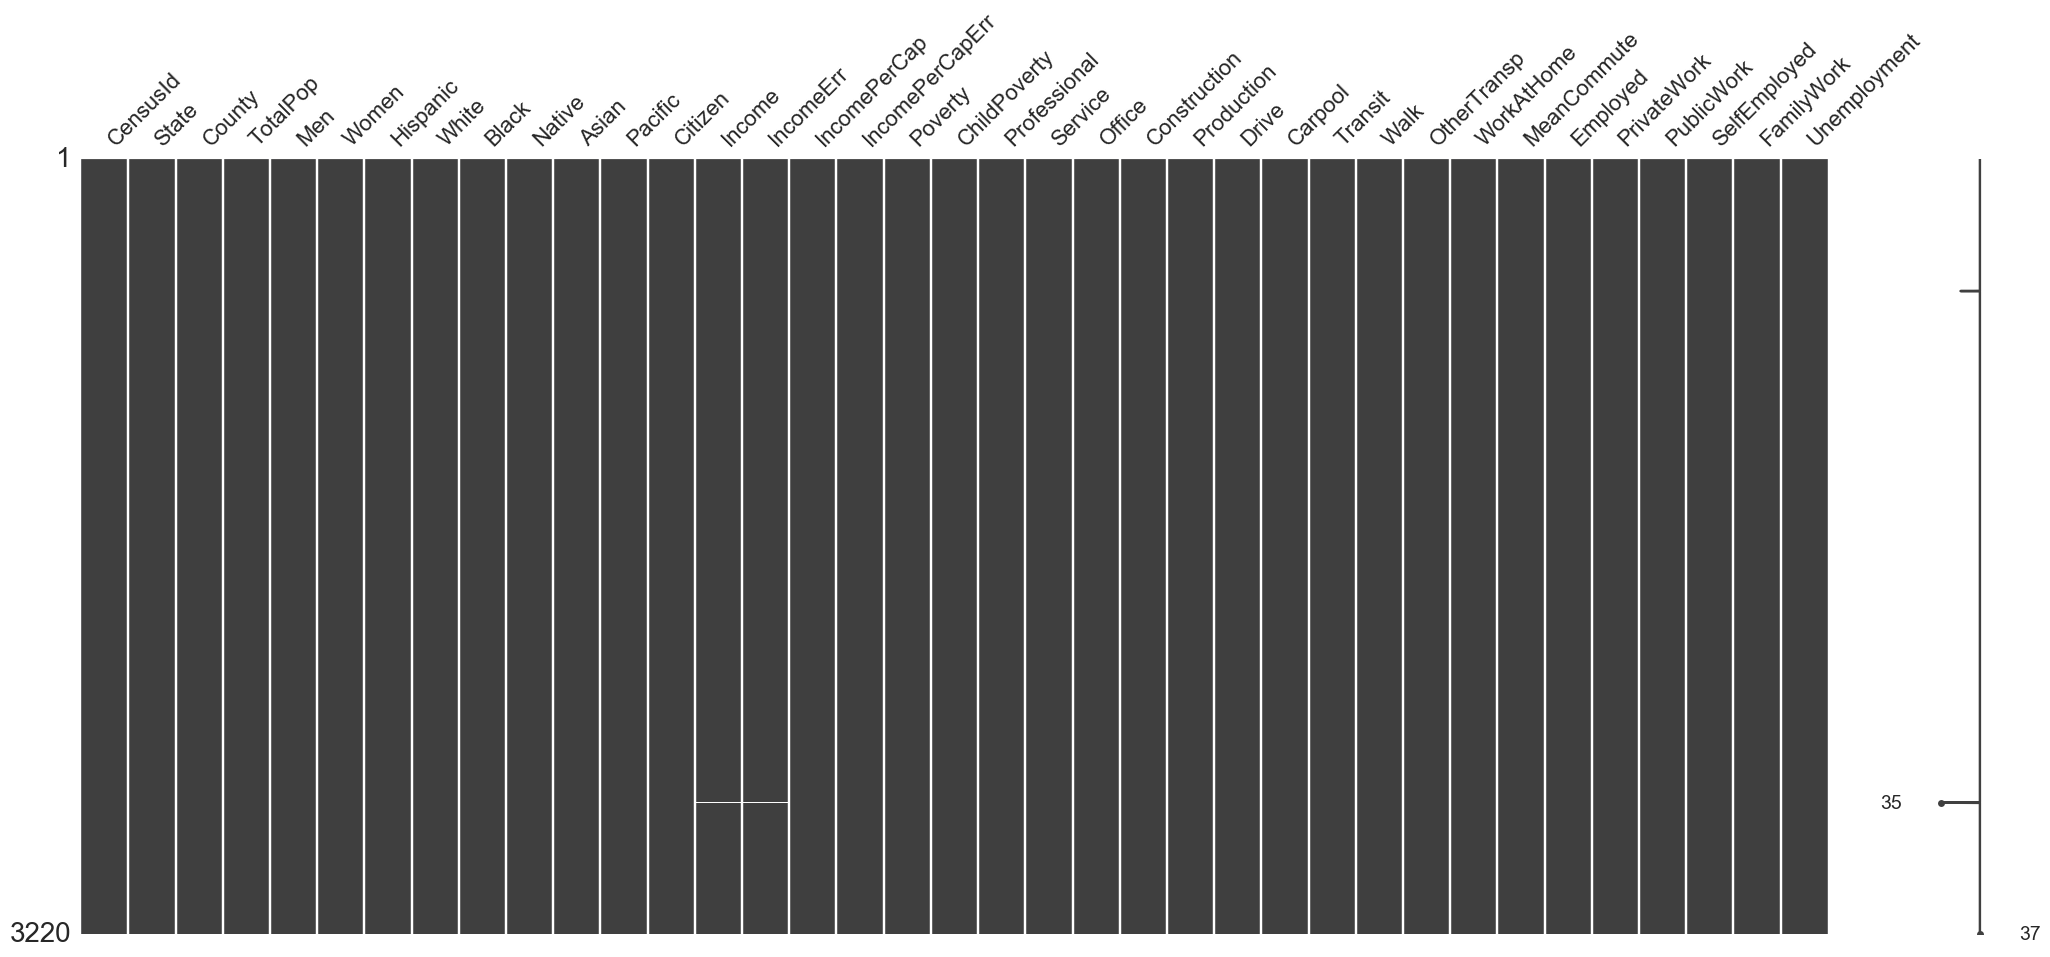

In [3]:
msno.matrix(df)

A further look up on the data shows that the missing rows are entry 548 and 2673 with population of around 100 - very insignificant. Hence, it is reasonable to drop these two entries.

In [4]:
df[df.isnull().any(axis=1)]

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
548,15005,Hawaii,Kalawao,85,42,43,4.7,37.6,0.0,0.0,...,40.3,14.9,3.0,9.2,64,25.0,64.1,10.9,0.0,0.0
2673,48301,Texas,Loving,117,74,43,35.0,41.0,0.0,12.8,...,8.1,0.0,16.1,25.4,62,71.0,27.4,1.6,0.0,15.1


In [5]:
df = df.dropna()

# Visualizing the Data

This is the most fun part of the project! Now you can go ahead and create your graphs (appropriately labeled of course), models, and other visualizations. Make sure you demonstrate your ability to create rich graphs by creating various different types of graphs, both for numerical as well as categorical data. 

Here are some types of graphs that you will want to create for this project. Remember to browse the online documentation for many Python graphing and visualization packages such as plotly, seaborn, and matplotlib if you need to borrow any code or get some help!
1. Creating multiple graphs that plot important financial indicators (y-axis) like the median annual income, per capita income, poverty rate, childhood poverty rate, and/or unemployment rate present in a particular county AGAINST several features in the dataset (x-axis) that might affect these factors, such as the total population of the county; the racial demographics of the county; or the occupations of different workers (professionals, service workers, construction, manufacturing).   

2. Using plotly as a graphing library to visualize these financial indicators in the 2015 American Community Survey data on a geographical map of the United States on a state-wide or county-based level (similar to what we did in class when we visualized global average temperatures for different countries on a global map). 

## Helper Functions

Weighted average

In [95]:
def weighted_average(df,data_col,weight_col,by_col):
    df['_data_times_weight'] = df[data_col]*df[weight_col]
    g = df.groupby(by_col)
    result = g['_data_times_weight'].sum()/g[weight_col].sum()
    return result

In [ ]:
df.columns

## Race

Get the aggregate racial distribution of each state

In [96]:
df["Total_White"] = df["White"]/100*df["TotalPop"]
df["Total_Black"] = df["Black"]/100*df["TotalPop"]
df["Total_Hispanic"] = df["Hispanic"]/100*df["TotalPop"]
df["Total_Native"] = df["Native"]/100*df["TotalPop"]
df["Total_Asian"] = df["Asian"]/100*df["TotalPop"]
df["Total_Pacific"] = df["Pacific"]/100*df["TotalPop"]

state_total_population = df[["State", "TotalPop", "Total_White", "Total_Black", 
                             "Total_Hispanic", "Total_Native", 
                             "Total_Asian", "Total_Pacific"]].groupby("State").aggregate(np.sum)
distribution = state_total_population.div(state_total_population["TotalPop"], axis=0).drop("TotalPop", axis=1)
distribution['check'] = distribution.sum(axis=1)

A `check` column was added to make sure that the percentage of various ethnicities add up to 100%. However, it seems that there exist some discrepancies. We further made a check to the proportion of different races [online](https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D) and found that the remaining unaccounted numbers could be contributed by `others` or `two or more races`.

<font color='red'> Question: should we add in `others`?</font>
- Hawaii only totals up to 80%

In [ ]:
distribution

## Occupation

Similar treatment as above to cross check data. Data seems to be consistent.

In [97]:
df["Total_Professional"] = df["Professional"]/100*df["TotalPop"]
df["Total_Service"] = df["Service"]/100*df["TotalPop"]
df["Total_Office"] = df["Office"]/100*df["TotalPop"]
df["Total_Construction"] = df["Construction"]/100*df["TotalPop"]
df["Total_Production"] = df["Production"]/100*df["TotalPop"]

state_total_occupation = df[["State", "TotalPop", "Total_Professional", "Total_Service", 
                             "Total_Office", "Total_Construction", 
                             "Total_Production"]].groupby("State").aggregate(np.sum)
occupation = state_total_occupation.div(state_total_occupation["TotalPop"], axis=0).drop("TotalPop", axis=1)
occupation['check'] = occupation.sum(axis=1)

In [ ]:
occupation

## Non-aggregated Plots (county-by-county)

### Effect of Total Population on Financial Performance

It seems that the larger the population of a county, the better it performs financially.

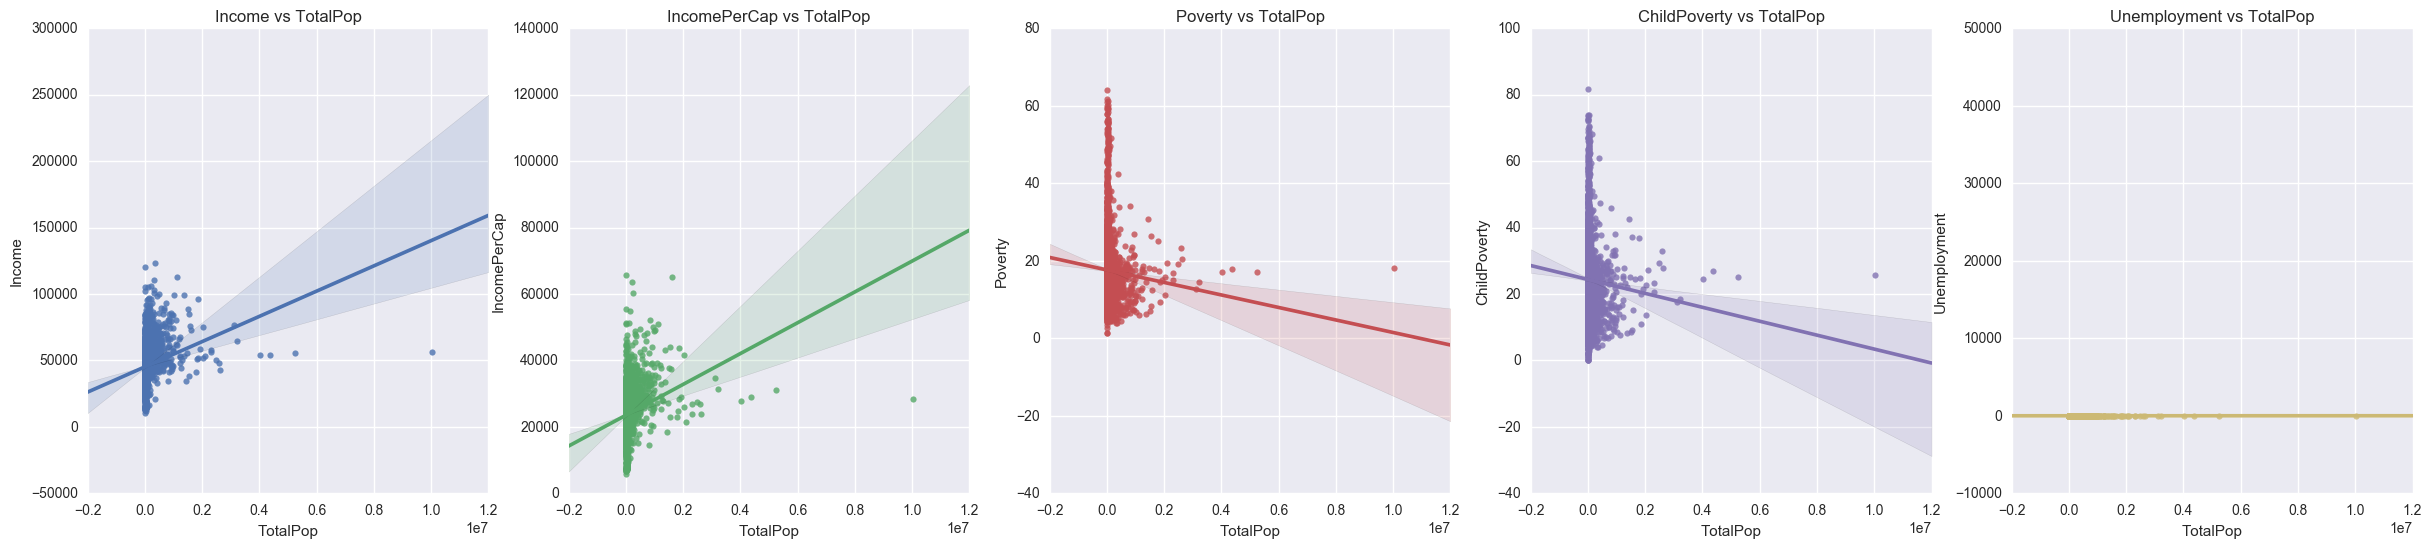

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30,6))
for i, indicator in enumerate(["Income", "IncomePerCap", "Poverty", "ChildPoverty", "Unemployment"]):
    sns.regplot(df['TotalPop'], df[indicator], ax=axes[i])
    axes[i].set_title(indicator + ' vs ' + 'TotalPop')

### Effect of Racial Demographic on Financial Performance

Using seaborn's regplot, we can observe the general trend between race and the indicators. In general, it is found that Asian and White groups seem to perform better in financial indicators (as seen from the upwards sloping regression lines).

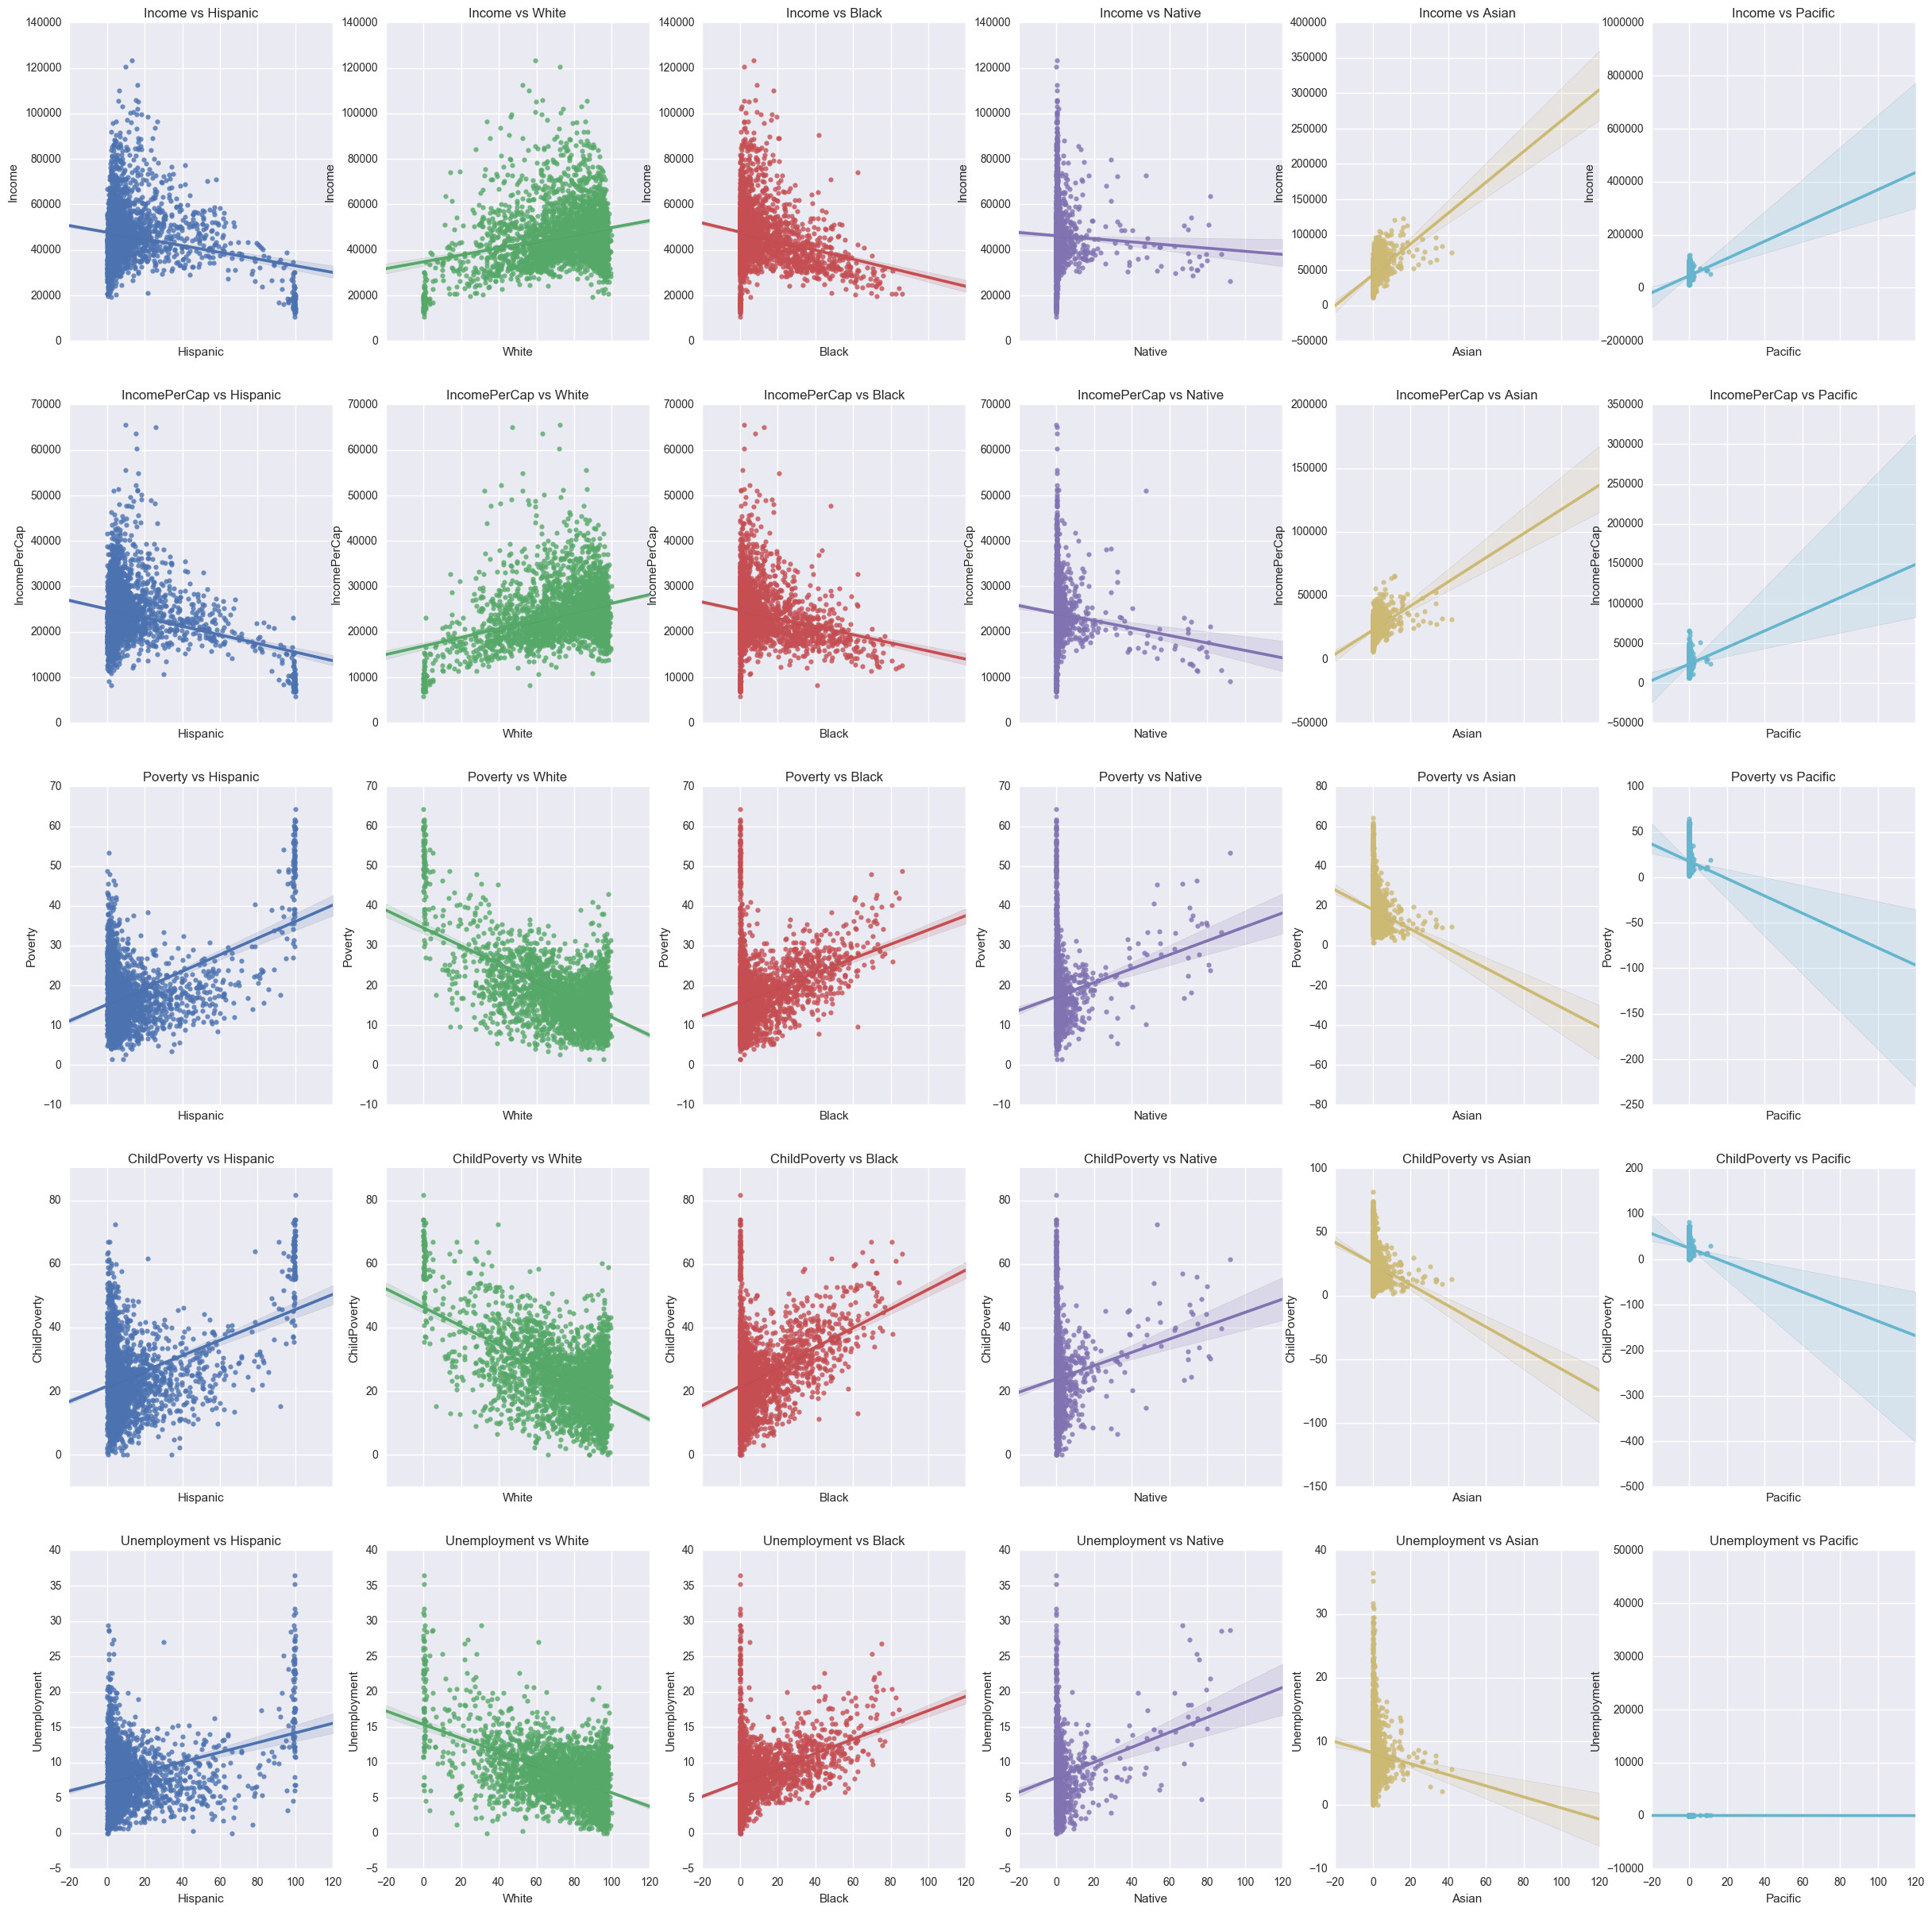

In [107]:
fig, axes = plt.subplots(nrows=5, ncols=6, sharex=True, figsize=(30,30))
for i, indicator in enumerate(["Income", "IncomePerCap", "Poverty", "ChildPoverty", "Unemployment"]):
    for j, race in enumerate(['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']):
        sns.regplot(df[race], df[indicator], ax=axes[i,j])
        axes[i, j].set_title(indicator + ' vs ' + race)

### Effect of Occupation on Financial Performance

The observation is not all that surprising. Professionals, followed by office workers, tend to have higher income and, thus, perform better financially. This extends to counties with higher proportion of professionals to perform better financially. The converse is true for lower paid industries as well.

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, sharex=True, figsize=(30,30))
for i, indicator in enumerate(["Income", "IncomePerCap", "Poverty", "ChildPoverty", "Unemployment"]):
    for j, job in enumerate(['Professional', 'Service', 'Office', 'Construction', 'Production']):
        sns.regplot(df[job], df[indicator], ax=axes[i,j])
        axes[i, j].set_title(indicator + ' vs ' + job)

## Aggregated Plots (state-by-state)
Getting the aggregate dataframe ready

In [101]:
state_df = distribution.drop('check', axis=1).join(occupation.drop('check', axis=1), how='outer')
state_df = state_df.join(df[['State', 'TotalPop']].groupby('State').aggregate(np.sum))

In [102]:
for indicator in ["Income", "IncomePerCap", "Poverty", "ChildPoverty", "Unemployment"]:
    state_df[indicator] = weighted_average(df, indicator, 'TotalPop', 'State')

In [ ]:
state_df.columns

### Interactive Plots

In [ ]:
fig = plotly.tools.make_subplots(rows=5, cols=1)
for i, indicator in enumerate(["Income", "IncomePerCap", "Poverty", "ChildPoverty", "Unemployment"]):
    trace = go.Scatter(x=state_df['TotalPop'], y=state_df[indicator], mode='markers', text=state_df.index, name=indicator)
    fig.append_trace(trace, i+1, 1)
fig['layout'].update(height=1200, width=600, title='Financial Performance vs Total Population')
py.iplot(fig)

### Geographical Representation of Data

In [99]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [ ]:
state_df.index

In [103]:
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

map_df = pd.DataFrame()

for col in state_df.columns:
    map_df[col] = state_df[col].astype(str)

map_df['text'] = map_df.index + '<br>' +\
                    'White '+map_df['Total_White']+' Black '+map_df['Total_Black']+'<br>'+\
                    'Hispanic '+map_df['Total_Hispanic']+' Native ' + map_df['Total_Native']+'<br>'+\
                    'Asian '+map_df['Total_Asian']+' Pacific '+map_df['Total_Pacific']

map_df = map_df.drop(['District of Columbia', 'Puerto Rico'])
            
data = [dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = pd.Series(map_df.index).map(arg=us_state_abbrev),
        z = map_df['Income'].astype(float),
        locationmode = 'USA-states',
        text = map_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "USD")
        ) ]

layout = dict(
        title = 'Median Income by State<br>(Hover for demographic breakdown)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
plotly.offline.iplot( fig, filename='d3-cloropleth-map' )

In [106]:
scl = [[0.0, 'rgb(255,220,224)'],[0.2, 'rgb(252,189,195)'],[0.4, 'rgb(249,153,163)'],\
            [0.6, 'rgb(240,105,119)'],[0.8, 'rgb(209,55,70)'],[1.0, 'rgb(161,10,25)']]

map_df = pd.DataFrame()

for col in state_df.columns:
    map_df[col] = state_df[col].astype(str)

map_df['text'] = map_df.index + '<br>' +\
                    'White '+map_df['Total_White']+' Black '+map_df['Total_Black']+'<br>'+\
                    'Hispanic '+map_df['Total_Hispanic']+' Native ' + map_df['Total_Native']+'<br>'+\
                    'Asian '+map_df['Total_Asian']+' Pacific '+map_df['Total_Pacific']

map_df = map_df.drop(['District of Columbia', 'Puerto Rico'])
            
data = [dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = pd.Series(map_df.index).map(arg=us_state_abbrev),
        z = map_df['Poverty'].astype(float),
        locationmode = 'USA-states',
        text = map_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "USD")
        ) ]

layout = dict(
        title = 'Poverty by State<br>(Hover for demographic breakdown)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
plotly.offline.iplot( fig, filename='d3-cloropleth-map' )

# Linear Regression

Make sure you also demonstrate your ability to create regressions on your data. In this part of the project, you will pick 3 financial indicators (like the median annual income, per capita income, poverty rate, childhood poverty rate, and/or unemployment rate) in the dataset. You will then train 3 linear regression models in scikit-learn that attempt to predict these 3 financial indicators of a county from the rest of the data collected in the dataset. You should analyze the accuracy of your linear regression model and report important predictors or features in your dataset that had the highest effect size on these 3 financial indicators (as discovered by your regression model). 

Optional: You can try adding regularization to see if you can get better results. 

Choosing the independent variables

## Per Capita Income

Feature selection

In [12]:
x_vals = ['TotalPop', 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific', 'Professional', 'Service',
          'Office', 'Construction', 'Production']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df[x_vals], df['Income'], test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

In [16]:
clf = ExtraTreesClassifier()
clf = clf.fit(X_train, y_train)
ranking = clf.feature_importances_ 

In [23]:
pd.Series(x_vals)[np.argsort(ranking)[::-1]]

7     Professional
8          Service
11      Production
0         TotalPop
10    Construction
2            White
1         Hispanic
9           Office
3            Black
5            Asian
4           Native
6          Pacific
dtype: object

In [58]:
selected_features = ["Professional", "White", "TotalPop"]
X_train, X_test, y_train, y_test = train_test_split(df[selected_features], df['Income'], test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

In [66]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_val, y_val)

0.40703039557986975

In [67]:
lr.score(X_train, y_train)

0.40707634406997856

In [68]:
mean_squared_error(y_train, lr.predict(X_train))

102377253.73188613

In [69]:
lr.coef_

array([  1.09403981e+03,   1.41233103e+02,   5.53452707e-03])

In [70]:
lr.intercept_

1048.4946410203629

In [71]:
lr.score(X_test, y_test)

0.38964930079418575

In [91]:
X = normalize(df[selected_features], axis=0)

In [92]:
poly = PolynomialFeatures(2)
X = poly.fit_transform(df[selected_features])
X_train, X_test, y_train, y_test = train_test_split(X, df['Income'], test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

In [94]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.48044295066249915